# Portfolio Optimization with Quadratic Programming

Exploring and preparing portfolio optimization used as a target in AI models. Described in chapters 4.2.2, 4.4 and 4.7.

Bases on examples shown during classes on Quadratic Optimization.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

## Data

In [2]:
from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [4]:
data_period = df_countries.loc[days_to_recalculate[21]:days_to_recalculate[22]]
data_period

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2001-10-04,70.7364,26.3875,12.9058,6.7949,10.0883,8.3372,8.1937,3.1985,9.7909,5.8211,...,6.2049,9.3449,7.2786,4.0823,9.1113,4.2435,4.4513,8.6852,8.4086,6.4014
2001-10-05,70.5981,26.0807,12.8879,6.7270,10.1173,8.2342,8.1687,3.3021,9.8152,5.9468,...,6.1654,9.2426,7.3317,4.1026,9.0025,4.2435,4.4258,8.6155,8.3183,6.3303
2001-10-08,70.1372,26.1727,13.0041,6.7202,10.1115,8.3372,8.2248,3.2676,9.7909,5.9468,...,6.1288,8.8214,7.4167,4.0319,8.8860,4.2580,4.3788,8.6076,8.2860,6.1880
2001-10-09,69.7620,25.6818,12.8254,6.6318,10.0651,8.2617,8.1189,3.2791,9.8697,5.7949,...,6.1986,9.3388,7.3424,4.0758,9.0181,4.2725,4.4753,8.6115,8.3505,6.1596
2001-10-10,71.3157,25.9886,13.0935,6.8968,10.4362,8.3509,8.3557,3.2637,10.0272,5.9416,...,6.2198,9.4953,7.5124,4.2086,9.1656,4.2821,4.5926,8.6080,8.6214,6.1596
2001-10-11,72.4218,26.5409,12.9773,6.7949,10.2912,8.3989,8.4741,3.3213,10.2635,5.9416,...,6.3110,9.5856,8.0436,4.2557,9.5540,4.4412,4.7368,8.7944,8.8986,6.3018
2001-10-12,72.0926,26.5409,12.8075,6.7270,10.4014,8.2342,8.4304,3.3175,10.2696,6.2140,...,6.2922,9.0861,7.9268,4.2707,9.5152,4.4412,4.8033,8.8416,8.7052,6.2591
2001-10-15,71.9610,26.2955,12.7807,6.7609,10.2275,8.3715,8.2560,3.3636,10.2696,6.1302,...,6.1970,8.8214,7.6611,4.2996,9.4919,4.5184,4.7394,8.8083,8.5440,6.3730
2001-10-16,72.4152,26.5103,12.8611,6.7270,10.3724,8.3303,8.3557,3.4173,9.7788,6.1616,...,6.2550,8.7973,8.0649,4.3526,9.6472,4.6052,4.7980,8.8390,8.5440,6.3303
2001-10-17,70.8747,26.4182,12.9147,6.7677,10.3782,8.1793,8.2560,3.3981,9.8576,6.4446,...,6.4027,8.8033,8.0011,4.4243,9.5618,4.6534,4.9383,8.8250,8.6407,6.4299


In [5]:
acwi_weights = data_provider.get_acwi_weights()
period_year = str(data_period.index[0].year)
acwi_weights = acwi_weights.loc[period_year]
acwi_weights

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2001-01-01,51.16,9.59,11.09,2.24,3.51,3.23,3.25,1.62,1.56,1.2,...,0.4,0.17,0.76,0.28,0.6,0.57,0.26,0.61,0.51,0.28


## Returns and variance

In [6]:
returns = np.log(data_period).diff().dropna()
cov_returns = returns.cov()
mean_returns = returns.mean()

In [7]:
mean_returns

United States     0.001962
Japan             0.000352
United Kingdom    0.001567
Canada            0.000432
France            0.002145
Switzerland       0.001200
Germany           0.002160
Australia         0.003604
Netherlands       0.001194
Sweden            0.004104
Hong Kong         0.000967
Spain             0.003249
Italy            -0.000112
Singapore        -0.001981
Denmark           0.000349
Finland           0.011343
Belgium          -0.001079
Norway            0.001539
China             0.000028
Taiwan            0.008033
India             0.004270
Korea             0.006750
Brazil            0.008133
Russia            0.007231
South Africa     -0.000419
Mexico            0.002146
Malaysia         -0.001977
dtype: float64

In [8]:
cov_returns

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
United States,0.000178,0.000132,0.000089,0.000067,0.000088,0.000078,0.000123,0.000046,1.317542e-05,0.000027,...,-0.000017,0.000066,1.619921e-04,0.000048,0.000135,0.000155,0.000011,0.000013,0.000141,-0.000023
Japan,0.000132,0.000164,0.000085,0.000046,0.000080,0.000059,0.000132,0.000027,2.337154e-06,0.000029,...,0.000004,0.000017,2.209349e-04,0.000057,0.000129,0.000166,0.000018,0.000042,0.000164,0.000010
United Kingdom,0.000089,0.000085,0.000189,0.000091,0.000176,0.000108,0.000159,0.000052,1.193822e-04,0.000182,...,0.000054,0.000071,1.224816e-04,0.000038,0.000124,0.000117,0.000018,0.000017,0.000134,-0.000011
Canada,0.000067,0.000046,0.000091,0.000219,0.000089,0.000052,0.000111,0.000021,9.425394e-05,0.000168,...,0.000045,0.000081,-3.661811e-05,0.000099,0.000057,0.000025,-0.000004,0.000004,0.000097,-0.000017
France,0.000088,0.000080,0.000176,0.000089,0.000236,0.000073,0.000190,0.000040,1.141310e-04,0.000248,...,0.000069,0.000074,1.594868e-04,0.000054,0.000150,0.000087,0.000055,0.000026,0.000139,-0.000028
Switzerland,0.000078,0.000059,0.000108,0.000052,0.000073,0.000196,0.000102,0.000012,1.248437e-04,-0.000020,...,-0.000008,0.000019,3.372925e-05,-0.000017,0.000078,0.000140,-0.000072,0.000010,0.000073,-0.000023
Germany,0.000123,0.000132,0.000159,0.000111,0.000190,0.000102,0.000259,0.000062,1.382849e-04,0.000207,...,0.000082,0.000152,2.541884e-04,0.000062,0.000232,0.000185,0.000049,0.000063,0.000222,-0.000013
Australia,0.000046,0.000027,0.000052,0.000021,0.000040,0.000012,0.000062,0.000160,5.454060e-05,0.000110,...,0.000039,0.000067,4.066567e-05,0.000052,0.000095,0.000043,0.000013,0.000013,0.000058,0.000039
Netherlands,0.000013,0.000002,0.000119,0.000094,0.000114,0.000125,0.000138,0.000055,4.593879e-04,0.000317,...,0.000142,0.000240,-9.186847e-07,0.000053,0.000142,0.000143,0.000079,0.000100,0.000125,0.000069
Sweden,0.000027,0.000029,0.000182,0.000168,0.000248,-0.000020,0.000207,0.000110,3.169903e-04,0.000841,...,0.000222,0.000105,3.075066e-05,0.000047,0.000105,0.000154,0.000155,0.000061,0.000094,0.000015


### Random portfolios

In [9]:
n = mean_returns.shape[0]
list_ret_p = []
list_std_p = []
list_w = []
for _ in range(10000):
    w = np.random.rand(n)           # random weights   
    w = w / np.sum(w)               # scaled to 1
    ret_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_ret_p.append(ret_p)
    list_std_p.append(std_p)
    list_w.append(w)

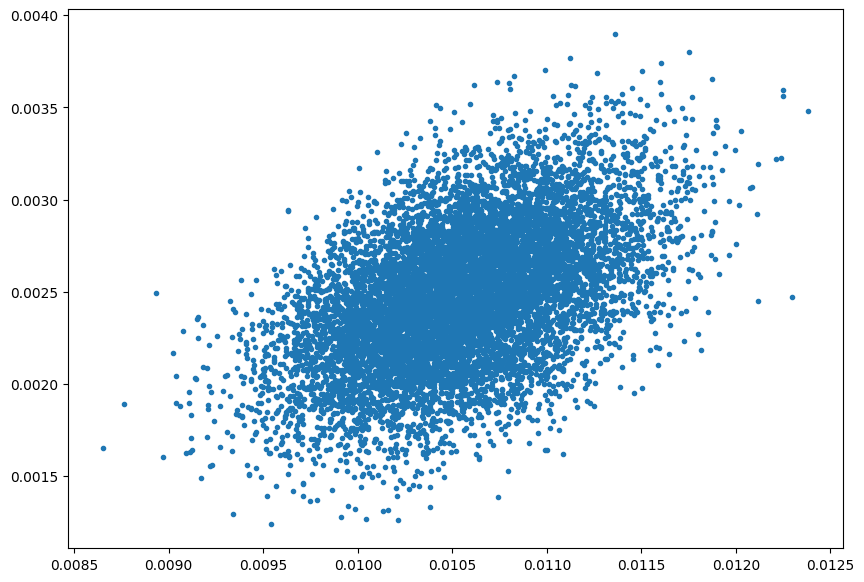

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_ret_p, '.')

In [11]:
list_w[0]

array([0.06185193, 0.03704892, 0.02762846, 0.03997377, 0.06508071,
       0.03018775, 0.03276629, 0.04779657, 0.02748944, 0.06225231,
       0.03238675, 0.03711662, 0.0003044 , 0.01413391, 0.06080542,
       0.04656472, 0.01837161, 0.01755739, 0.04453372, 0.03849415,
       0.00714514, 0.04717814, 0.00916111, 0.04677973, 0.04434491,
       0.04651392, 0.05653221])

### Constraints

'Normal' contraints

In [43]:
df_constraints = pd.DataFrame(index=acwi_weights.columns,
                              columns=['Ref ACWI Weight', 
                                       'Min Allowed Weight', 
                                       'Max Allowed Weight'])

w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    weights = round(acwi_weights.loc[:, country].values[0]/100, 4)
    min_weight = round(weights*0.5, 4)
    if min_weight < 0.001:
        min_weight = 0.001

    max_weight = round(weights*2, 4)
    if max_weight < 0.03:
        max_weight = 0.03
    elif max_weight > 0.75:
        max_weight = 0.75

    constraints += [
        w[i] >= min_weight,
        w[i] <= max_weight
    ]
    
    df_constraints.loc[country, :] = [weights, min_weight, max_weight]
    i += 1

#df_constraints.to_csv('normal_constraints.csv')
df_constraints

,Ref ACWI Weight,Min Allowed Weight,Max Allowed Weight
United States,0.5116,0.2558,0.75
Japan,0.0959,0.048,0.1918
United Kingdom,0.1109,0.0554,0.2218
Canada,0.0224,0.0112,0.0448
France,0.0351,0.0176,0.0702
Switzerland,0.0323,0.0162,0.0646
Germany,0.0325,0.0162,0.065
Australia,0.0162,0.0081,0.0324
Netherlands,0.0156,0.0078,0.0312
Sweden,0.012,0.006,0.03


Tight constraints

In [22]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    weights = round(acwi_weights.loc[:, country].values[0]/100, 4)
    min_weight = round(weights*0.7, 4)
    if min_weight < 0.001:
        min_weight = 0.001

    max_weight = round(weights*1.5, 4)
    if max_weight < 0.02:
        max_weight = 0.02
    elif max_weight > 0.7:
        max_weight = 0.7

    constraints += [
        w[i] >= min_weight,
        w[i] <= max_weight
    ]
    
    print(i, country, '(', weights, ') from', min_weight, 'to', max_weight)
    i += 1

0 United States ( 0.5116 ) from 0.3581 to 0.7
1 Japan ( 0.0959 ) from 0.0671 to 0.1438
2 United Kingdom ( 0.1109 ) from 0.0776 to 0.1664
3 Canada ( 0.0224 ) from 0.0157 to 0.0336
4 France ( 0.0351 ) from 0.0246 to 0.0526
5 Switzerland ( 0.0323 ) from 0.0226 to 0.0485
6 Germany ( 0.0325 ) from 0.0228 to 0.0488
7 Australia ( 0.0162 ) from 0.0113 to 0.0243
8 Netherlands ( 0.0156 ) from 0.0109 to 0.0234
9 Sweden ( 0.012 ) from 0.0084 to 0.02
10 Hong Kong ( 0.0089 ) from 0.0062 to 0.02
11 Spain ( 0.0138 ) from 0.0097 to 0.0207
12 Italy ( 0.0185 ) from 0.0129 to 0.0277
13 Singapore ( 0.0036 ) from 0.0025 to 0.02
14 Denmark ( 0.003 ) from 0.0021 to 0.02
15 Finland ( 0.0045 ) from 0.0031 to 0.02
16 Belgium ( 0.0042 ) from 0.0029 to 0.02
17 Norway ( 0.004 ) from 0.0028 to 0.02
18 China ( 0.0017 ) from 0.0012 to 0.02
19 Taiwan ( 0.0076 ) from 0.0053 to 0.02
20 India ( 0.0028 ) from 0.002 to 0.02
21 Korea ( 0.006 ) from 0.0042 to 0.02
22 Brazil ( 0.0057 ) from 0.004 to 0.02
23 Russia ( 0.0026 ) f

Loose constraints

In [23]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    weights = round(acwi_weights.loc[:, country].values[0]/100, 4)
    min_weight = round(weights*0.3, 4)
    max_weight = round(weights*3, 4)
    if max_weight < 0.04:
        max_weight = 0.04
    elif max_weight > 0.8:
        max_weight = 0.8

    if min_weight <= 0.001:
        min_weight = 0
        constraints.append(w[i] <= max_weight)
    else:
        constraints += [
            w[i] >= min_weight,
            w[i] <= max_weight
        ]
    
    print(i, country, '(', weights, ') from', min_weight, 'to', max_weight)
    i += 1

0 United States ( 0.5116 ) from 0.1535 to 0.8
1 Japan ( 0.0959 ) from 0.0288 to 0.2877
2 United Kingdom ( 0.1109 ) from 0.0333 to 0.3327
3 Canada ( 0.0224 ) from 0.0067 to 0.0672
4 France ( 0.0351 ) from 0.0105 to 0.1053
5 Switzerland ( 0.0323 ) from 0.0097 to 0.0969
6 Germany ( 0.0325 ) from 0.0098 to 0.0975
7 Australia ( 0.0162 ) from 0.0049 to 0.0486
8 Netherlands ( 0.0156 ) from 0.0047 to 0.0468
9 Sweden ( 0.012 ) from 0.0036 to 0.04
10 Hong Kong ( 0.0089 ) from 0.0027 to 0.04
11 Spain ( 0.0138 ) from 0.0041 to 0.0414
12 Italy ( 0.0185 ) from 0.0055 to 0.0555
13 Singapore ( 0.0036 ) from 0.0011 to 0.04
14 Denmark ( 0.003 ) from 0 to 0.04
15 Finland ( 0.0045 ) from 0.0013 to 0.04
16 Belgium ( 0.0042 ) from 0.0013 to 0.04
17 Norway ( 0.004 ) from 0.0012 to 0.04
18 China ( 0.0017 ) from 0 to 0.04
19 Taiwan ( 0.0076 ) from 0.0023 to 0.04
20 India ( 0.0028 ) from 0 to 0.04
21 Korea ( 0.006 ) from 0.0018 to 0.04
22 Brazil ( 0.0057 ) from 0.0017 to 0.04
23 Russia ( 0.0026 ) from 0 to 0.04

### Efficient Frontier Calculations

In [24]:
def efficient_frontier(returns, w, constraints, n_samples=20):
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, sigma)

    prob = cp.Problem(cp.Maximize(ret - gamma*risk), constraints)
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(-0.9, 10, num=n_samples)

    portfolio_weights = []
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)
    return ret_data, risk_data, portfolio_weights

In [25]:
ret_data, risk_data, portfolio_weights = efficient_frontier(returns, w, constraints)

### Optimal portfolio with Max Sharpe value

In [26]:
sharpes = ret_data/risk_data 
idx = np.argmax(sharpes)
optimal_ret, optimal_risk = ret_data[idx], risk_data[idx]
optimal_portfolio = pd.Series(portfolio_weights[idx],
                              index=returns.columns).round(3)

In [27]:
sharpes

array([0.25705612, 0.25705612, 0.26110023, 0.31500971, 0.34059634,
       0.2851603 , 0.17052968, 0.16906261, 0.1689884 , 0.16896852,
       0.16896321, 0.16896179, 0.16896141, 0.16896131, 0.16896129,
       0.16896128, 0.16896128, 0.16896128, 0.16896128, 0.16896128])

Dibujamos la frontera eficiente y donde ocurre la cartera optima

In [38]:
optimal_portfolio

United States     0.290
Japan             0.029
United Kingdom    0.033
Canada            0.066
France            0.011
Switzerland       0.097
Germany           0.010
Australia         0.049
Netherlands       0.021
Sweden            0.040
Hong Kong         0.003
Spain             0.041
Italy             0.006
Singapore         0.001
Denmark           0.022
Finland           0.040
Belgium           0.001
Norway            0.040
China            -0.082
Taiwan            0.040
India             0.040
Korea             0.040
Brazil            0.040
Russia            0.040
South Africa      0.040
Mexico            0.002
Malaysia          0.040
dtype: float64

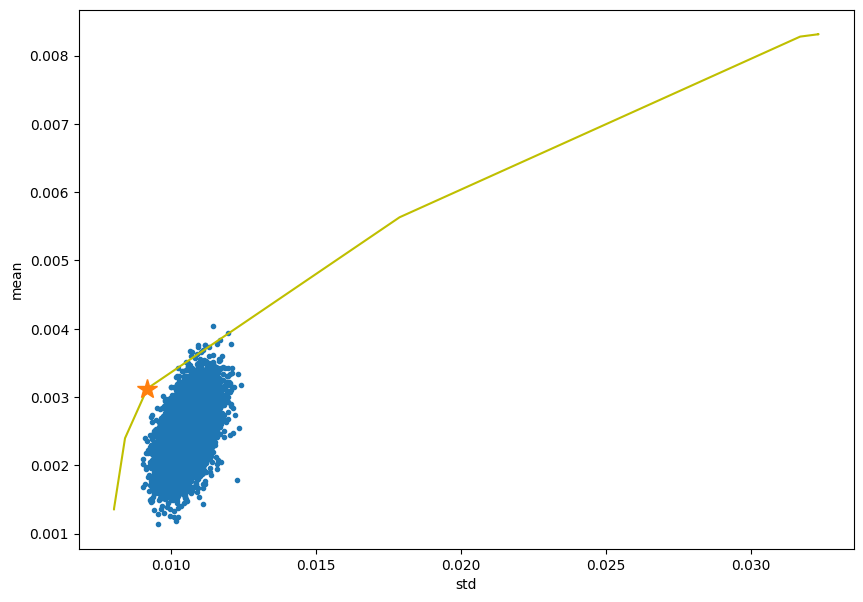

In [39]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_ret_p, '.')
ax.plot(risk_data, ret_data, 'y')
ax.plot(optimal_risk, optimal_ret, '*', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')

### Dividing code into functions

In [40]:
def get_constraints(w, acwi_weights):
    constraints = [cp.sum(w) == 1]
    i = 0

    for country in acwi_weights.columns:
        weights = acwi_weights.loc[:, country].values[0]
        min_weight = round(weights*0.5/100, 3)
        if min_weight < 0.001:
            min_weight = 0.001

        max_weight = round(weights*2/100, 3)
        if max_weight < 0.03:
            max_weight = 0.03
        elif max_weight > 0.7:
            max_weight = 0.7

        constraints += [
            w[i] >= min_weight,
            w[i] <= max_weight
        ]
        i += 1
    
    return constraints

In [41]:
def get_optimal_portfolio(data_period, acwi_weights):
    returns = np.log(data_period).diff().dropna()

    w = cp.Variable(acwi_weights.shape[1])
    constraints = get_constraints(w, acwi_weights)

    ret_data, risk_data, portfolio_weights = efficient_frontier(
        returns, w, constraints)

    sharpes = ret_data/risk_data
    idx = np.argmax(sharpes)
    optimal_portfolio = pd.Series(portfolio_weights[idx],
                                  index=returns.columns).round(3)

    return optimal_portfolio

In [42]:
get_optimal_portfolio(data_period, acwi_weights)

United States     0.431
Japan             0.048
United Kingdom    0.055
Canada            0.011
France            0.070
Switzerland       0.032
Germany           0.016
Australia         0.032
Netherlands       0.008
Sweden            0.030
Hong Kong         0.004
Spain             0.030
Italy             0.009
Singapore         0.002
Denmark           0.002
Finland           0.030
Belgium           0.002
Norway            0.030
China             0.001
Taiwan            0.030
India             0.030
Korea             0.030
Brazil            0.030
Russia            0.030
South Africa      0.003
Mexico            0.003
Malaysia          0.001
dtype: float64

### Test PortfolioOptimizer class

In [43]:
from PortfolioOptimizer import PortfolioOptimizer

In [44]:
optimizer = PortfolioOptimizer()
w, constraints = optimizer.get_normal_constraints(acwi_weights)
optimizer.get_optimal_portfolio(data_period, w, constraints)

United States     0.321
Japan             0.048
United Kingdom    0.055
Canada            0.038
France            0.061
Switzerland       0.065
Germany           0.016
Australia         0.032
Netherlands       0.022
Sweden            0.030
Hong Kong         0.004
Spain             0.030
Italy             0.009
Singapore         0.002
Denmark           0.002
Finland           0.030
Belgium           0.002
Norway            0.030
China             0.001
Taiwan            0.030
India             0.030
Korea             0.030
Brazil            0.030
Russia            0.030
South Africa      0.030
Mexico            0.003
Malaysia          0.019
dtype: float64

## Constraint using ranking

Building constraints for ranked countries from Learning to Rate model

In [45]:
random_ranking = list(range(len(data_provider.selected_countries)))
np.random.shuffle(random_ranking)

ranked_countries = pd.Series(random_ranking, index=data_provider.selected_countries)
ranked_countries

United States     19
Japan             25
United Kingdom    17
Canada             5
France             4
Switzerland       13
Germany           18
Australia          1
Netherlands       15
Sweden             0
Hong Kong          7
Spain             10
Italy             22
Singapore         12
Denmark           23
Finland           14
Belgium           26
Norway            11
China              8
Taiwan            21
India             16
Korea              2
Brazil             9
Russia            20
South Africa       6
Mexico             3
Malaysia          24
dtype: int64

In [46]:
acwi_weights

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2001-01-01,51.16,9.59,11.09,2.24,3.51,3.23,3.25,1.62,1.56,1.2,...,0.4,0.17,0.76,0.28,0.6,0.57,0.26,0.61,0.51,0.28


In [47]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    benchmark_weight = acwi_weights.loc[:, country].values[0]
    benchmark_weight = round(benchmark_weight/100, 3)
    rank = ranked_countries[country]

    if i < 3:
        if rank < 10:
            min_weight = benchmark_weight
            max_weight = benchmark_weight*2
            if max_weight > 0.7:
                max_weight = 0.7
        else:
            min_weight = benchmark_weight*0.5
            max_weight = benchmark_weight
    else:
        min_weight = 0.001
        max_weight = 0.03

    constraints += [
        w[i] >= min_weight,
        w[i] <= max_weight
    ]
    print(i, country, '(', benchmark_weight, ') from',
          min_weight, 'to', max_weight)

    if i >= 3 and rank > 0:
        higher_ranked_country = ranked_countries[
            ranked_countries == rank-1].index[0]
        higher_ranked_country_idx = acwi_weights.columns.get_loc(
            higher_ranked_country)
        if higher_ranked_country_idx >= 3:
            constraints.append(w[i] <= w[higher_ranked_country_idx])
            print(country, '<=', higher_ranked_country)
        elif rank > 1:
            higher_ranked_country = ranked_countries[
                ranked_countries == rank-2].index[0]
            higher_ranked_country_idx = acwi_weights.columns.get_loc(
                higher_ranked_country)
            if higher_ranked_country_idx >= 3:
                constraints.append(w[i] <= w[higher_ranked_country_idx])
                print(country, '<=', higher_ranked_country)

    i += 1

0 United States ( 0.512 ) from 0.256 to 0.512
1 Japan ( 0.096 ) from 0.048 to 0.096
2 United Kingdom ( 0.111 ) from 0.0555 to 0.111
3 Canada ( 0.022 ) from 0.001 to 0.03
Canada <= France
4 France ( 0.035 ) from 0.001 to 0.03
France <= Mexico
5 Switzerland ( 0.032 ) from 0.001 to 0.03
Switzerland <= Singapore
6 Germany ( 0.032 ) from 0.001 to 0.03
Germany <= India
7 Australia ( 0.016 ) from 0.001 to 0.03
Australia <= Sweden
8 Netherlands ( 0.016 ) from 0.001 to 0.03
Netherlands <= Finland
9 Sweden ( 0.012 ) from 0.001 to 0.03
10 Hong Kong ( 0.009 ) from 0.001 to 0.03
Hong Kong <= South Africa
11 Spain ( 0.014 ) from 0.001 to 0.03
Spain <= Brazil
12 Italy ( 0.019 ) from 0.001 to 0.03
Italy <= Taiwan
13 Singapore ( 0.004 ) from 0.001 to 0.03
Singapore <= Norway
14 Denmark ( 0.003 ) from 0.001 to 0.03
Denmark <= Italy
15 Finland ( 0.005 ) from 0.001 to 0.03
Finland <= Switzerland
16 Belgium ( 0.004 ) from 0.001 to 0.03
Belgium <= Malaysia
17 Norway ( 0.004 ) from 0.001 to 0.03
Norway <= Sp

## Applying additional constraints to model predictions

In [63]:
# Simulate predictions from ML model
predictions = np.random.random((27))
predictions /= predictions.sum()
predictions

array([0.07055022, 0.0458019 , 0.05643654, 0.05988066, 0.05420181,
       0.05492588, 0.05504239, 0.05000604, 0.0208648 , 0.02145594,
       0.04954074, 0.00787452, 0.00806522, 0.00500741, 0.03660583,
       0.07998647, 0.00843244, 0.025556  , 0.01010036, 0.00175055,
       0.01232775, 0.02363964, 0.03795036, 0.04739148, 0.06477977,
       0.02165776, 0.07016752])

In [64]:
def apply_tight_contraints_to_predictions(predictions, data_period, acwi_weights):
    returns = np.log(data_period).diff().dropna()
    sigma = returns.cov().values

    w, constraints = optimizer.get_tight_constraints(acwi_weights)

    objective = cp.Minimize(cp.quad_form(w - predictions, sigma))

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value

In [65]:
apply_tight_contraints_to_predictions(predictions, data_period, acwi_weights)

array([0.358     , 0.067     , 0.078     , 0.02290781, 0.03647695,
       0.023     , 0.03850822, 0.024     , 0.023     , 0.02      ,
       0.01359113, 0.021     , 0.028     , 0.02      , 0.02      ,
       0.02      , 0.003     , 0.02      , 0.02      , 0.01584326,
       0.02      , 0.00849992, 0.01917271, 0.02      , 0.02      ,
       0.02      , 0.02      ])